<a href="https://colab.research.google.com/github/sruthi1996/DeepLearning/blob/master/MNIST_LenetArchitecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import gzip
import numpy as np
import pandas as pd
from time import time
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

MNIST dataset is being downloaded from the official website: http://yann.lecun.com/exdb/mnist/

Official database of mnist handwriten digits

In [0]:
from requests import get
def download_file(url, file_name):
    with open(file_name, "wb") as file:
        response = get(url)
        file.write(response.content)

In [0]:
download_file('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

In [0]:
def read_mnist(images_path: str, labels_path: str):
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Loading 28x28 = 784 pixel flat images and converting them to 28x28 pixel images; using reshape
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)
        
    return features, labels

In [0]:
train_data = {}
test_data = {}
train_data['features'], train_data['labels'] = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test_data['features'], test_data['labels'] = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

In [71]:
!pip install seaborn==0.9.0

In [72]:
print('No. of training images:', train_data['features'].shape[0])
print('No. of test images:', test_data['features'].shape[0])

No. of training images: 60000
No. of test images: 10000


In [0]:
def display_image(position):
    image = train_data['features'][position].squeeze()
    plt.title('Example %d. Label: %d' % (position, train_data['labels'][position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

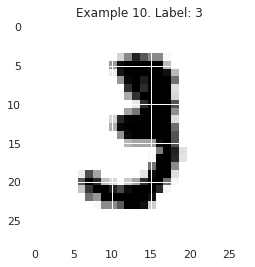

In [74]:
display_image(10)

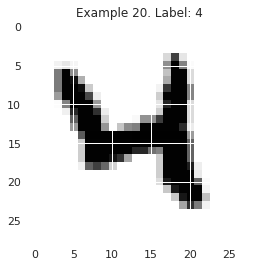

In [75]:
display_image(20)

In [76]:
train_labels_count = np.unique(train_data['labels'], return_counts=True)
df_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
df_train_labels

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


In [77]:
test_labels_count = np.unique(test_data['labels'], return_counts=True)
df_test_labels = pd.DataFrame({'Label':test_labels_count[0], 'Count':test_labels_count[1]})
df_test_labels

,Label,Count
0,0,980
1,1,1135
2,2,1032
3,3,1010
4,4,982
5,5,892
6,6,958
7,7,1028
8,8,974
9,9,1009


In [0]:
validation_data = {}
train_data['features'], validation_data['features'], train_data['labels'], validation_data['labels'] = train_test_split(train_data['features'], train_data['labels'], test_size=0.2, random_state=0)

In [79]:
print('No. of training images:', train_data['features'].shape[0])
print('No. of validation images:', validation_data['features'].shape[0])

No. of training images: 48000
No. of validation images: 12000


The LeNet architecture accepts a 32x32 pixel images as input, mnist data is 28x28 pixels. We simply pad the images with zeros to overcome that.

In [80]:
# Pad images with 0s
train_data['features']      = np.pad(train_data['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
validation_data['features'] = np.pad(validation_data['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
test_data['features']       = np.pad(test_data['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
print("Updated Image Shape: {}".format(train_data['features'][0].shape))

Updated Image Shape: (32, 32, 1)


In [0]:
model = keras.Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=10, activation = 'softmax'))

In [82]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 30, 30, 6)         60        
_________________________________________________________________
average_pooling2d_11 (Averag (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_12 (Averag (None, 6, 6, 16)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 120)               69240     
_________________________________________________________________
dense_17 (Dense)             (None, 84)               

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [0]:
EPOCHS = 10
BATCH_SIZE = 256

In [0]:
X_train, y_train = train_data['features'], to_categorical(train_data['labels'])
X_validation, y_validation = validation_data['features'], to_categorical(validation_data['labels'])

train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

In [86]:
print('No. of training images:', train_data['features'].shape[0])
print('No. of validation images:', validation_data['features'].shape[0])

steps_per_epoch = X_train.shape[0]//BATCH_SIZE
validation_steps = X_validation.shape[0]//BATCH_SIZE

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=True, callbacks=[tensorboard])

No. of training images: 48000
No. of validation images: 12000
Epoch 1/10
187/187 [==============================] - 16s 88ms/step - loss: 1.0815 - accuracy: 0.8256 - val_loss: 0.3465 - val_accuracy: 0.9383
Epoch 2/10
187/187 [==============================] - 16s 87ms/step - loss: 0.1626 - accuracy: 0.9506 - val_loss: 0.1569 - val_accuracy: 0.9629
Epoch 3/10
187/187 [==============================] - 16s 87ms/step - loss: 0.1048 - accuracy: 0.9686 - val_loss: 0.1012 - val_accuracy: 0.9742
Epoch 4/10
187/187 [==============================] - 16s 87ms/step - loss: 0.0776 - accuracy: 0.9768 - val_loss: 0.0550 - val_accuracy: 0.9751
Epoch 5/10
187/187 [==============================] - 17s 89ms/step - loss: 0.0626 - accuracy: 0.9808 - val_loss: 0.1111 - val_accuracy: 0.9787
Epoch 6/10
187/187 [==============================] - 16s 86ms/step - loss: 0.0513 - accuracy: 0.9838 - val_loss: 0.0337 - val_accuracy: 0.9806
Epoch 7/10
187/187 [==============================] - 16s 88ms/step - loss

In [88]:
score = model.evaluate(test_data['features'], to_categorical(test_data['labels']))
print('Test data loss is :', score[0])
print('Test data accuracy is:', score[1])

10000/10000 [==============================] - 2s 205us/step
Test data loss is : 0.047132752065037496
Test data accuracy is: 0.9854999780654907
